In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.functional as F
import numpy as np
import pandas as pd
import random
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data prep

In [2]:
#somehow load two parquet files into colab - drive?

In [3]:
# !pip install fastparquet
# !pip install selfies

In [4]:
import selfies as sf
data = pd.read_parquet('./GRU_data/combined_selfies.parquet')
alphabet = sf.get_alphabet_from_selfies(data.selfies)
#alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet.add("[start]")
alphabet.add("[end]")
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 10
print("Pad to len:", pad_to_len)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}

Pad to len: 119


In [5]:
import re
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len=None):
        self.alphabet = alphabet
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
        self.pad_to_len = pad_to_len
    def vectorize(self, selfie, no_special=False):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        if no_special:
            splited = self.split_selfi(selfie)
        elif self.pad_to_len is None:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]']
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        X = np.zeros((len(splited), len(self.alphabet)))
        for i in range(len(splited)):
            X[i, self.char2idx[splited[i]]] = 1
        return X
    def devectorize(self, ohe, remove_special=False):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(ohe.shape[0]):
            idx = np.argmax(ohe[j, :])
            if remove_special and (self.idx2char[idx] == '[start]' or self.idx2char[idx] == '[end]'):
                continue
            selfie_str += self.idx2char[idx]
        return selfie_str
    def idxize(self, selfie, no_special=False):
        if no_special:
            splited = self.split_selfi(selfie)
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        return np.array([self.char2idx[s] for s in splited])
    def deidxize(self, idx):
        return "".join([self.idx2char[i] for i in idx])
    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)

In [6]:
vectorizer = SELFIESVectorizer(alphabet, pad_to_len=pad_to_len)

In [7]:
from torch.utils.data import Dataset, DataLoader
class GRUDatasetv2(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_parquet(smiles_fp)
        self.selfies = pd.read_parquet(selfies)
        # self.X = self.prepare_X(self.smiles_fp)
        # self.X = np.array([self.reconstruct_fp(fp) for fp in self.X])
        self.selfies= self.prepare_y(self.selfies)
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.selfies[idx][0]
        vectorized_selfie = self.vectorizer.idxize(raw_selfie)
        # esentially, we want to predict the next symbol in the SELFIE and offset the target by one makes teaching forcing implicit
        vectorized_selfie = vectorized_selfie
        raw_X = self.smiles_fp.fps[idx]
        X = np.array(raw_X, dtype=int)
        X_reconstructed = self.reconstruct_fp(X)

        return torch.from_numpy(X_reconstructed).float(), torch.from_numpy(vectorized_selfie).long()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values
    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [8]:
dataset = GRUDatasetv2('GRU_data/combined_klek.parquet', 'GRU_data/combined_selfies.parquet', vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 402863
Train size: 362576
Test size: 40287


# NN architecture

In [9]:
class EncoderNet(nn.Module):
    def __init__(self, fp_size, encoding_size):
        super(EncoderNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(fp_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, encoding_size)
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        return out


class DecoderNet(nn.Module):
    def __init__(self, dictionary_size, emb_size, hidden_size, num_layers, drop_prob):
        super(DecoderNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        # embedding layer [batch_size, seq_len] -> [batch_size, seq_len, emb_size]
        self.embedding = nn.Embedding(dictionary_size, emb_size)
        # gru layer [batch_size, seq_len, emb_size] -> [batch_size, seq_len, hidden_size]
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, dropout=drop_prob, batch_first=True)
        # fully connected layer [batch_size, seq_len, hidden_size] -> [batch_size, seq_len, dictionary_size]
        self.fc = nn.Linear(hidden_size, dictionary_size)
        self.max_len = vectorizer.pad_to_len

    def forward(self, input, hidden):
        emdedded = self.embedding(input)
        prediction, hidden = self.gru(emdedded, hidden)
        prediction = self.fc(prediction)
        return prediction, hidden


    def init_hidden(self, encoded):
        return encoded.unsqueeze(0).repeat(self.num_layers, 1, 1).to(device)
    
class Autoencoder(nn.Module):
    def __init__(self, input_size=4860, 
                 encoding_size=256, 
                 dictionary_size=len(alphabet), 
                 emb_size=256, 
                 hidden_size=256, 
                 num_layers=2, 
                 teacher_forcing_ratio=0.5,
                 drop_prob=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = EncoderNet(input_size, encoding_size)
        self.decoder = DecoderNet(dictionary_size, emb_size, hidden_size, num_layers, drop_prob)
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src,trg, teacher_forcing_ratio=None):
        teacher_forcing_ratio = self.teacher_forcing_ratio if teacher_forcing_ratio is None else teacher_forcing_ratio
        # if in evaluation mode we don't use teacher forcing
        if not self.training:
            teacher_forcing_ratio = 0
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        outputs = []
        hidden = self.encoder(src)
        hidden = hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        input = trg[:, 0].unsqueeze(1)
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs.append(output)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = torch.argmax(output, dim=2)
            input = trg[:, t].unsqueeze(1) if teacher_force else top1
        outputs = torch.cat(outputs, dim=1)
        return outputs

# Training

In [10]:
from tqdm.notebook import tqdm
import wandb

def pretty_str_compare(str, str_pred, color=True):
    if len(str_pred) > len(str):
        str += '-' * (len(str_pred) - len(str))
    elif len(str_pred) < len(str):
        str_pred += '-' * (len(str) - len(str_pred))
    print(f'Target:  {str}', end='\n')
    # print difference in red color
    print('Output:  ', end='')
    for act, pred in zip(str, str_pred):
        if act != pred:
            if color:
                print('\033[91m', end='')
            print(pred, end='')
            if color:
                print('\033[0m', end='')
        else:
            print(pred, end='')

def train(autoencoder, dataloader, val_dataloader, num_epochs=10, device=device):
    
    learning_rate = 0.001
    teacher_forcing_ratio = 0.5
    criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.char2idx['[nop]'])
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    autoencoder.train()
    config = dict()
    config['learning_rate'] = learning_rate
    config['teacher_forcing_ratio'] = teacher_forcing_ratio
    config['criterion'] = criterion
    config['optimizer'] = optimizer
    config['num_epochs'] = num_epochs
    config['Trainable parameters'] = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
    config['Embedding size'] = autoencoder.decoder.embedding.embedding_dim
    config['Hidden size'] = autoencoder.decoder.hidden_size
    config['Number of layers'] = autoencoder.decoder.num_layers
    config['Dropout'] = autoencoder.decoder.gru.dropout
    config['Batch size'] = batch_size
    config['Dataset size'] = len(dataloader.dataset) * batch_size

    

    wandb.init(project="selfie-autoencoder_v2", config=config)
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (src, trg) in enumerate(tqdm(dataloader)):
            src = src.to(device)
            trg = trg.to(device)
            optimizer.zero_grad()
            output = autoencoder(src, trg, teacher_forcing_ratio)
            trg = trg[:, 1:]
            # print(f'Output shape: {output.shape}')
            # print(f'Target shape: {trg.shape}')
            # print('Target:', trg)
            #replace 1 and 2 dimension
            output = output.permute(0, 2, 1)
            # print(f'Output shape after view: {output.shape}')
            # print(f'Target shape after view: {trg.shape}')
            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if epoch % 2 == 0:
            autoencoder.eval()
            with torch.no_grad():
                visual_examples_src, visual_examples_trg = next(iter(dataloader))
                visual_examples_src = visual_examples_src.to(device)[:5]
                visual_examples_trg = visual_examples_trg.to(device)[:5]
                visual_examples_outputs = autoencoder(visual_examples_src, visual_examples_trg, teacher_forcing_ratio)
                visual_examples_outputs = visual_examples_outputs.permute(0, 2, 1)
                visual_examples_outputs = torch.argmax(visual_examples_outputs, dim=1)
                visual_examples_outputs = visual_examples_outputs.cpu().numpy()
                visual_examples_outputs = np.array([vectorizer.deidxize(o) for o in visual_examples_outputs])
                visual_examples_trg = visual_examples_trg.cpu().numpy()
                visual_examples_trg = np.array([vectorizer.deidxize(o) for o in visual_examples_trg])
                print(f'Epoch {epoch} loss: {epoch_loss / len(dataloader)}')
                for i in range(len(visual_examples_outputs)):
                    pretty_str_compare(visual_examples_trg[i][7:], visual_examples_outputs[i])
                    print('\n-------------------\n')
        # evaluate on validation set
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (src, trg) in enumerate(tqdm(val_dataloader)):
                src = src.to(device)
                trg = trg.to(device)
                output = autoencoder(src, trg, teacher_forcing_ratio)
                trg = trg[:, 1:]
                output = output.permute(0, 2, 1)
                loss = criterion(output, trg)
                val_loss += loss.item()
            wandb.log({'val_loss': val_loss / len(val_dataloader)})
            autoencoder.train()
        print(f'Epoch {epoch} loss: {epoch_loss / len(dataloader)}')
        wandb.log({'loss': epoch_loss / len(dataloader)})
    wandb.finish()
    return autoencoder

## Sweep config

In [11]:
import pprint
sweep_config = {
    'method': 'bayes',
    }
metric = {
    'name': 'val_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'encoding_size': { 'values': [32, 64, 128, 256, 512, 1024] },
    'emb_size': { 'values': [32, 64, 128, 256, 512, 1024] }, 
    'num_layers': { 'values': [1, 2, 3, 4, 5] },
    'teacher_forcing_ratio': { 'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] }, # 'min': 0.0, 'max': 0.5, 'step': 0.1 },
    'drop_prob': { 'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] },
    'epochs': { 'value': 20}
    }


sweep_config['parameters'] = parameters_dict
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.01
        'distribution': 'uniform',
        'min': 0.0,
        'max': 0.01
      },
    'batch_size': {
        'value': 256
      }
    })
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'value': 256},
                'drop_prob': {'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
                'emb_size': {'values': [32, 64, 128, 256, 512, 1024]},
                'encoding_size': {'values': [32, 64, 128, 256, 512, 1024]},
                'epochs': {'value': 20},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.01,
                                  'min': 0.0},
                'num_layers': {'values': [1, 2, 3, 4, 5]},
                'teacher_forcing_ratio': {'values': [0.0,
                                                     0.1,
                                                     0.2,
                                                     0.3,
                                                     0.4,
                                                     0.5,
                                                     0.6,


In [12]:
# sweep id is created only once, then string is used to run the sweep
#sweep_id = wandb.sweep(sweep_config, project="selfie-autoencoder_v2")
sweep_id = 'jjgazi3d'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_hyper(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # Config is a variable that holds and saves hyperparameters and inputs
        config = wandb.config
        # Define model, optimizer, and loss function
        autoencoder = Autoencoder(encoding_size=config.encoding_size, 
                                  emb_size=config.emb_size, 
                                  hidden_size=config.encoding_size,
                                  num_layers=config.num_layers, 
                                    teacher_forcing_ratio=config.teacher_forcing_ratio,
                                  drop_prob=config.drop_prob).to(device)
        dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size, drop_last=True)
        val_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=config.batch_size, drop_last=True)
        for i in tqdm(range(config.epochs)):
            avg_loss = train_epoch(autoencoder, dataloader, config.learning_rate)
            val_loss, table = evaluate(autoencoder, val_dataloader)
            wandb.log({'epoch': i, 'loss': avg_loss})
            wandb.log({'epoch': i, 'val_loss': val_loss})
            wandb.log({'epoch': i, 'table': table})


def train_epoch(autoencoder, dataloader, learning_rate):
    autoencoder.train()
    criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.char2idx['[nop]'])
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    epoch_loss = 0
    for batch_idx, (src, trg) in enumerate(tqdm(dataloader)):
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output = autoencoder(src, trg)
        trg = trg[:, 1:]
        output = output.permute(0, 2, 1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        wandb.log({'batch_loss': loss.item()})
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

def evaluate(autoencoder, dataloader):
    autoencoder.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.char2idx['[nop]'])
    epoch_loss = 0
    for batch_idx, (src, trg) in enumerate(tqdm(dataloader)):
        src = src.to(device)
        trg = trg.to(device)
        output = autoencoder(src, trg)
        trg = trg[:, 1:]
        output = output.permute(0, 2, 1)
        loss = criterion(output, trg)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    with torch.no_grad():
                visual_examples_src, visual_examples_trg = next(iter(dataloader))
                visual_examples_src = visual_examples_src.to(device)[:5]
                visual_examples_trg = visual_examples_trg.to(device)[:5]
                visual_examples_outputs = autoencoder(visual_examples_src, visual_examples_trg, teacher_forcing_ratio)
                visual_examples_outputs = visual_examples_outputs.permute(0, 2, 1)
                visual_examples_outputs = torch.argmax(visual_examples_outputs, dim=1)
                visual_examples_outputs = visual_examples_outputs.cpu().numpy()
                visual_examples_outputs = np.array([vectorizer.deidxize(o) for o in visual_examples_outputs])
                visual_examples_trg = visual_examples_trg.cpu().numpy()
                visual_examples_trg = np.array([vectorizer.deidxize(o) for o in visual_examples_trg])
                #log visual examples as table to wandb
                data = [[src, trg] for src, trg in zip(visual_examples_trg, visual_examples_outputs)]
                table = wandb.Table(data=data, columns = ["Target", "Output"])
                     
    return avg_loss, table


In [15]:
wandb.agent(sweep_id,project="selfie-autoencoder_v2", function=train_hyper, count=1)

wandb: Agent Starting Run: 56n82juf with config:
wandb: 	batch_size: 256
wandb: 	drop_prob: 0
wandb: 	emb_size: 32
wandb: 	encoding_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.00045079172714391217
wandb: 	num_layers: 5
wandb: 	teacher_forcing_ratio: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anton-siomchen (mldd23). Use `wandb login --relogin` to force relogin


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1416 [00:00<?, ?it/s]

In [38]:
# Hubert jakby co, to możesz wczytać model z pliku, 
# żeby nie trzeba było czekać 200 epok
loaded_model = Autoencoder(4860, 300, 300, 42, 2, 0.0).to(device)
loaded_model.load_state_dict(torch.load('./GRU_data/model_h300_e500_teacher_forcing.pt'))

<All keys matched successfully>

In [39]:
x, y = next(iter(test_loader))
x = x.to(device)
x.size()

torch.Size([64, 4860])

In [40]:
encoded, decoded = loaded_model(x)

# GRU output to SELFIES

In [41]:
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()

In [42]:
# set largers value to 1 and others to 0
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()
selfies_out = []
for i, original in zip(decoded_indices, y):
    vectorized = []
    #print(f'Decoded: {i}')
    #convert to one-hot
    for number in i:
        v = np.zeros(42)
        v[number] = 1
        vectorized.append(v)
    vectorized = np.array(vectorized)
    selfies_out.append(vectorizer.devectorize(vectorized, remove_special=True))
    print(f'Original: {vectorizer.devectorize(original.cpu().numpy())} \n')
    print(f'Decoded:  {vectorizer.devectorize(vectorized)}')
    print('------------------')

Original: [C][C][Branch2][Ring1][=Branch1][C][=Branch1][C][=O][N][S][=Branch1][C][=O][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][Cl][C][C][N][Ring1][P][C][=Branch1][C][=O][C][C][C][C][C][C][Ring1][=Branch1][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop] 

Decoded:  [O-1][#C][=N][\O][=N][NH1][Branch2][I][#N][#N][=O][#N][=S][/O][#N][=O][=S][=S][/O][\O][=S][\O][=Ring1][#N][P][#N][#N][#N][#Branch2][#Branch2][#N][#N][=Ring2][=Ring2][#Branch2][end][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop

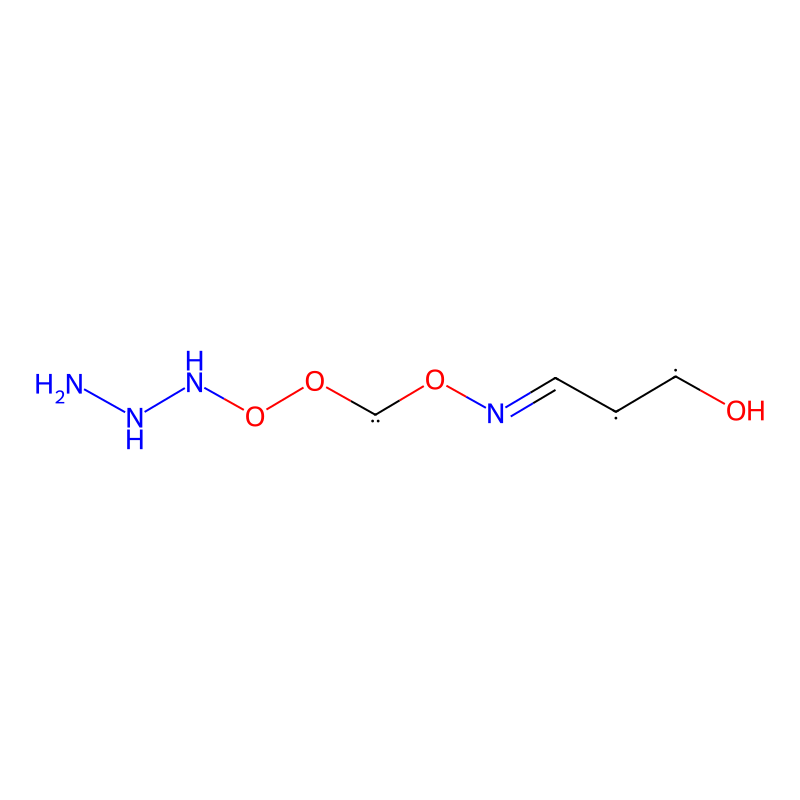

In [46]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = []
for selfie in selfies_out:
    smile = sf.decoder(selfie, attribute=False)
    smiles.append(smile)

ms = []
for smile in smiles:
    ms.append(Chem.MolFromSmiles(smile))
Draw.MolToImage(ms[5], size=(800, 800), kekulize=True)